In [1]:
'''
Load relative modules
'''
import numpy as np
import numpy.random as rng
import torch 
import torch.nn as nn 
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
import pandas as pd
import math
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data generators and model specifications

## X
In the following experiments, we view X as fixed. \
$\Sigma=\begin{bmatrix} 1 & \rho & \cdots & \rho \\ \rho & 1 & \cdots & \rho \\ \vdots & \vdots & \ddots & \vdots \\ \rho & \rho & \cdots & 1 \end{bmatrix},$ \
Draw $N$ samples from $MVN(0, \Sigma)$, and then normalize $X$. \
Let $\bar{X_i}=0, ||X_i||^2_2=N, i=1,...,p$

In [2]:
p = 10 # number of dimension
N = 500 # sample size
rho = 0 # correlation between features

In [3]:
'''Generate X'''
rng.seed(0)
Sigma = np.ones((p, p)) * rho
Sigma = Sigma + np.diag(np.ones(p) * (1-rho))
X = rng.multivariate_normal(np.zeros(p), Sigma, N)
X = X - np.mean(X, axis=0)
X = X * np.sqrt(N / np.sum(X**2, axis=0))

## Logistic
Prior: $\beta \sim MVN(0,I_p),$ \
$y_i|x_i,\beta \sim Bernoulli(p_i), \text{with } \text{logit}(p_i)=x_i^t \beta.$

In [4]:
class Generator_logistic(object):
    def __init__(self, p, N, X):
        self.p = p
        self.N = N
        self.X = X
    
    def generate_samples(self, n, seed):
        rng.seed(seed)
        beta = rng.randn(n, p)
        prob = np.exp(beta@X.T) / (1 + np.exp(beta@X.T))
        Y = rng.binomial(1,prob)
        return beta, Y        

In [5]:
gen_logistic = Generator_logistic(p, N, X)

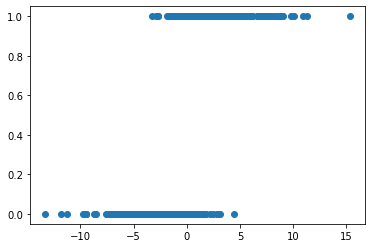

In [6]:
beta0_logistic, Y0_logistic = gen_logistic.generate_samples(1, 0)
beta0_logistic = beta0_logistic.reshape(p, 1)
Y0_logistic = Y0_logistic.reshape(-1)
plt.plot(X@beta0_logistic, Y0_logistic, 'o')
plt.show()

Generate training and validation set

In [22]:
beta_logistic_train, Y_logistic_train = gen_logistic.generate_samples(1000000, 123)
beta_logistic_val, Y_logistic_val = gen_logistic.generate_samples(100000, 456)

In [23]:
np.save('./data/beta_logistic_train.npy', beta_logistic_train)
np.save('./data/beta_logistic_val.npy', beta_logistic_val)
np.save('./data/Y_logistic_train.npy', Y_logistic_train)
np.save('./data/Y_logistic_val.npy', Y_logistic_val)

In [7]:
beta_logistic_train = np.load('./data/beta_logistic_train.npy')
beta_logistic_val = np.load('./data/beta_logistic_val.npy')
Y_logistic_train = np.load('./data/Y_logistic_train.npy')
Y_logistic_val = np.load('./data/Y_logistic_val.npy')

Standardization

In [8]:
mean_logistic = Y_logistic_train.mean(0)
std_logistic = Y_logistic_train.std(0)
Y_logistic_train = (Y_logistic_train - mean_logistic) / std_logistic
Y_logistic_val = (Y_logistic_val - mean_logistic) / std_logistic

## Normal
Prior: $\beta \sim MVN(0,I_p)$,\
$y_i|x_i,\beta \sim N(x_i^t \beta, 1).$

In [9]:
class Generator_normal(object):
    def __init__(self, p, N, X):
        self.p = p
        self.N = N 
        self.X = X 
    
    def generate_samples(self, n, seed):
        rng.seed(seed)
        beta = rng.randn(n, p)
        Y = beta@X.T + rng.randn(n, N)
        return beta, Y

In [10]:
gen_normal = Generator_normal(p, N, X)

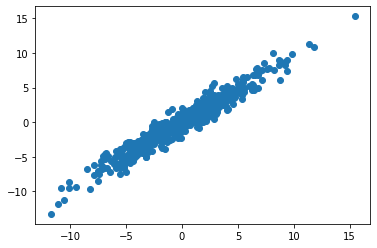

In [11]:
beta0_normal, Y0_normal = gen_normal.generate_samples(1, 0)
beta0_normal = beta0_normal.reshape(p, 1)
Y0_normal = Y0_normal.reshape(-1)
plt.plot(Y0_normal, X@beta0_normal, 'o')
plt.show()

Generate training and validation set

In [12]:
beta_normal_train, Y_normal_train = gen_normal.generate_samples(1000000, 123)
beta_normal_val, Y_normal_val = gen_normal.generate_samples(10000, 456)

Standardization

In [13]:
mean_normal = Y_normal_train.mean(0)
std_normal = Y_normal_train.std(0)
Y_normal_train = (Y_normal_train - mean_normal) / std_normal
Y_normal_val = (Y_normal_val - mean_normal) / std_normal

# Neural network functions

### Two layers MLP
* Two hidden layers, with 1024 hidden units each.
* Replace MSE loss with quantile loss to do quantile regression.\
Quantile loss:\
$\rho_{\tau}(r)=r(\tau-\mathbb{I}_{(r<0)})=max(r*\tau,r*(\tau-1))$\
where $r=\theta-\hat\theta,$ and $\tau$ is the quantile.

In [14]:
class MLP(nn.Module):
    def __init__(self, N, p):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(N, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, p)
        self.relu = nn.ReLU()
        self.mseloss = nn.MSELoss()
        self.bceloss = nn.BCEWithLogitsLoss()
    
    def forward(self, input):
        u = self.relu(self.fc1(input))
        u = self.relu(self.fc2(u))
        output = self.fc3(u)
        return output

    def get_mseloss(self, data, targ):
        output = self.forward(data)
        loss = self.mseloss(output, targ)
        return loss

    def get_bceloss(self, data, targ):
        output = self.forward(data)
        loss = self.bceloss(output, targ)
        return loss
    
    def get_quanloss(self, data, targ, tau):
        output = self.forward(data)
        errs = targ - output
        loss = torch.mean(torch.max((tau-1)*errs, tau*errs))
        return loss

In [15]:
''' 
 loss_type: 'mse' for posterior mean, 'bce' for predicting whether beta is 0, 'quantile' for posterior quantile.
q: Only used when loss_type is 'quantile', q quantile.
'''
def train_epoch(model, optimizer, train_data, train_labels, batch_size, loss_type, q):
    model.train()
    n = train_data.shape[0]
    train_loss = 0.
    for i in range(math.ceil(n/batch_size)):
        data = torch.from_numpy(train_data[(i*batch_size):min((i+1)*batch_size, n-1)]).type(torch.float).to(device)
        targ = torch.from_numpy(train_labels[(i*batch_size):min((i+1)*batch_size, n-1)]).type(torch.float).to(device)
        if loss_type == 'mse':
            loss = model.get_mseloss(data, targ)
        elif loss_type == 'bce':
            loss = model.get_bceloss(data, targ)
        elif loss_type == 'quantile':
            loss = model.get_quanloss(data, targ, q)
        train_loss += loss.item() * data.shape[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return train_loss/n 

def model_test(model, test_data, test_labels, loss_type='mse', q=0.5):
    model.eval()
    with torch.no_grad():
        data = torch.from_numpy(test_data).type(torch.float).to(device)
        targ = torch.from_numpy(test_labels).type(torch.float).to(device)
        if loss_type == 'mse':
            loss = model.get_mseloss(data, targ)
        elif loss_type == 'bce':
            loss = model.get_bceloss(data, targ)
        elif loss_type == 'quantile':
            loss = model.get_quanloss(data, targ, q)
    return loss.item()

def train_model(model, lr, batch_size, epochs, train_data, train_labels, loss_type='mse', q=0.5, val_data=None, val_labels=None):
    assert loss_type in ['mse', 'bce', 'quantile']
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    val_losses = []
    for i in range(epochs):
        train_loss = train_epoch(model, optimizer, train_data, train_labels, batch_size, loss_type, q)
        print('Epoch: {}'.format(i+1))
        print('Train loss: {:.5f}'.format(train_loss))
        train_losses.append(train_loss)
        if isinstance(val_data, np.ndarray):
            val_loss = model_test(model, val_data, val_labels, loss_type, q)
            print('Val loss: {:.5f}'.format(val_loss))
            val_losses.append(val_loss)
    return train_losses, val_losses

def predict(model, Y):
    model.eval()
    with torch.no_grad():
        data = torch.from_numpy(Y).type(torch.float).to(device)
        pred = model(data)
    return pred.detach().cpu().numpy()

### Simultaneous Quantile Regression (SQR)
Solve $\hat f \in {arg\,min}_f \frac{1}{n} \sum^n_{i=1}\mathbb{E}_{\tau \sim U[0,1]}[l_{\tau}(f(x_i,\tau),y_i)]$, with sampling fresh random quantile levels $\tau \sim U[0,1]$ for each training point and mini-batch during training.
Advantages:
* One model for all quantiles
* Greatly alleviate the undesired phenomena of crossing quantiles.

In [16]:
'''
https://github.com/facebookresearch/SingleModelUncertainty
'''
class QuantileLoss(nn.Module):
    def __init__(self):
        super(QuantileLoss, self).__init__()

    def forward(self, yhat, y, tau):
        diff = yhat - y
        mask = (diff.ge(0).float() - tau).detach()   # \tau - I{r<0}, r=y-yhat
        return (mask * diff).mean()

def augment(x, tau=None):
    if tau is None:
        tau = torch.zeros(x.size(0), 1).fill_(0.5).to(device)
    elif type(tau) == float:
        tau = torch.zeros(x.size(0), 1).fill_(tau).to(device)

    return torch.cat((x, (tau - 0.5) * 12), 1)

In [17]:
def train_epoch_sqr(model, optimizer, train_data, train_labels, batch_size, q):
    n = train_data.shape[0]
    train_loss = 0.
    qloss = QuantileLoss()

    for i in range(math.ceil(n/batch_size)):
        data = torch.from_numpy(train_data[(i*batch_size):min((i+1)*batch_size, n-1)]).type(torch.float).to(device)
        targ = torch.from_numpy(train_labels[(i*batch_size):min((i+1)*batch_size, n-1)]).type(torch.float).to(device)

        if q=="all":
            taus = torch.rand(data.size(0), 1).to(device)
        else:
            taus = torch.zeros(data.size(0), 1).fill_(q).to(device)

        loss = qloss(model(augment(data, taus)), targ, taus)
        train_loss += loss.item() * data.shape[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return train_loss/n 

def train_model_sqr(model, lr, batch_size, epochs, train_data, train_labels, q='all'):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    for i in range(epochs):
        train_loss = train_epoch_sqr(model, optimizer, train_data, train_labels, batch_size, q)
        print('Epoch: {}'.format(i+1))
        print('Train loss: {:.5f}'.format(train_loss))
        train_losses.append(train_loss)
    return train_losses

def predict_sqr(model, Y, q):
    model.eval()
    with torch.no_grad():
        data = torch.from_numpy(Y.reshape(1,-1)).type(torch.float).to(device)
        pred = model(augment(data, q))
    return pred.cpu().numpy() 

def model_test_sqr(model, test_data, test_labels, q='all'):
    model.eval()
    qloss = QuantileLoss()
    with torch.no_grad():
        data = torch.from_numpy(test_data).type(torch.float).to(device)
        targ = torch.from_numpy(test_labels).type(torch.float).to(device)

        if q=="all":
            taus = torch.rand(data.size(0), 1).to(device)
        else:
            taus = torch.zeros(data.size(0), 1).fill_(q).to(device)

        loss = qloss(model(augment(data, taus)), targ, taus)
    return loss.item()    

# Stan

## Normal

In [18]:
stan_normal = """
data{
    int<lower=0> N; // number of data items
    int<lower=0> K; // number of predictors
    matrix[N, K] x; // predictor matrix
    vector[N] y; // outcome vector
}
parameters{
    vector[K] beta;
}
model{
    y ~ normal(x * beta, 1);
    beta ~ normal(0, 1);
}
"""
sm_normal = pystan.StanModel(model_code=stan_normal)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ee6ac1110f8f96784e9bd023529127d7 NOW.


In [19]:
data_normal = {'N': X.shape[0], 'K': X.shape[1], 'x': X, 'y': Y0_normal}
fit_normal = sm_normal.sampling(data=data_normal, iter=1000, chains=4, warmup=500, thin=1, seed=0)

In [20]:
summary_normal = fit_normal.summary()
df_normal = pd.DataFrame(summary_normal['summary'], 
                  columns=summary_normal['summary_colnames'], 
                  index=summary_normal['summary_rownames'])
df_normal

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta[1],1.774981,0.000710,0.045171,1.684725,1.745476,1.775533,1.804559,1.861987,4044.096285,0.998858
beta[2],0.412039,0.000700,0.044032,0.325604,0.382727,0.412111,0.441064,0.500004,3958.881167,0.998811
beta[3],0.934169,0.000806,0.043919,0.847935,0.905856,0.933056,0.963270,1.022710,2970.371964,0.999575
beta[4],2.257327,0.000755,0.045319,2.164998,2.228258,2.257389,2.287809,2.346365,3603.761581,0.998650
beta[5],1.834606,0.000727,0.043531,1.752946,1.804258,1.834343,1.863431,1.920149,3582.175586,0.999714
beta[6],-1.000081,0.000760,0.045475,-1.091082,-1.031070,-1.000420,-0.968277,-0.910733,3584.523029,0.999124
beta[7],0.934271,0.000694,0.044605,0.848617,0.903816,0.934807,0.966477,1.016537,4126.983506,0.999506
beta[8],-0.131797,0.000712,0.045656,-0.220845,-0.163150,-0.132328,-0.100176,-0.041660,4113.745219,0.998383
beta[9],-0.038236,0.000718,0.045324,-0.127469,-0.068877,-0.037960,-0.007376,0.050132,3983.356772,0.998712
beta[10],0.452640,0.000705,0.043375,0.371201,0.423426,0.451547,0.480722,0.542239,3789.687360,0.998483


In [21]:
stan_mean_normal = df_normal['mean'][:p].to_numpy()
stan_median_normal = df_normal['50%'][:p].to_numpy()
stan_q025_normal = df_normal['2.5%'][:p].to_numpy()
stan_q975_normal = df_normal['97.5%'][:p].to_numpy()

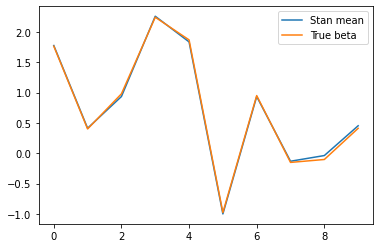

In [22]:
plt.plot(range(10), stan_mean_normal)
plt.plot(range(10), beta0_normal)
plt.legend(['Stan mean', 'True beta'], loc='upper right')
plt.show()

## Logistic

In [23]:
stan_logistic = """
data{
    int<lower=0> N; // number of data items
    int<lower=0> K; // number of predictors
    matrix[N, K] x; // predictor matrix
    int<lower=0, upper=1> y [N]; // outcome vector
}
parameters{
    vector[K] beta;
}
model{
    y ~ bernoulli_logit(x * beta);
    beta ~ normal(0, 1);
}
"""
sm_logistic = pystan.StanModel(model_code=stan_logistic)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6b8a583f21c91a4cf71b24b70a1fbffd NOW.


In [24]:
data_logistic = {'N': X.shape[0], 'K': X.shape[1], 'x': X, 'y': Y0_logistic}
fit_logistic = sm_logistic.sampling(data=data_logistic, iter=4000, chains=4, warmup=500, thin=1, seed=1)

In [25]:
summary_logistic = fit_logistic.summary()
df_logistic = pd.DataFrame(summary_logistic['summary'], 
                  columns=summary_logistic['summary_colnames'], 
                  index=summary_logistic['summary_rownames'])
df_logistic

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
beta[1],1.893170,0.001959,0.204994,1.509158,1.752297,1.886742,2.028042,2.303989,10945.485064,0.999947
beta[2],0.556592,0.001072,0.147133,0.269770,0.457772,0.555897,0.655104,0.846385,18837.818478,0.999968
beta[3],0.999956,0.001440,0.164048,0.688239,0.887386,0.997280,1.107598,1.327095,12979.661876,1.000004
beta[4],1.693387,0.001780,0.192329,1.331169,1.562311,1.687811,1.819562,2.079303,11674.995386,0.999950
beta[5],1.781911,0.001907,0.198408,1.404864,1.645146,1.778869,1.913951,2.179701,10827.148819,0.999955
beta[6],-1.051097,0.001447,0.163414,-1.381716,-1.158946,-1.047611,-0.940442,-0.740283,12755.941308,1.000121
beta[7],1.022101,0.001347,0.161504,0.719257,0.910842,1.017873,1.130660,1.350192,14369.802852,1.000045
beta[8],-0.289562,0.000949,0.142381,-0.571010,-0.385429,-0.288062,-0.191710,-0.016429,22525.214656,1.000190
beta[9],-0.353163,0.000927,0.141170,-0.636717,-0.447355,-0.351719,-0.257371,-0.077642,23190.997802,0.999964
beta[10],0.674750,0.001168,0.156455,0.371055,0.570069,0.672323,0.777806,0.990508,17957.514333,0.999797


In [26]:
stan_mean_logistic = df_logistic['mean'][:p].to_numpy()
stan_median_logistic = df_logistic['50%'][:p].to_numpy()
stan_q025_logistic = df_logistic['2.5%'][:p].to_numpy()
stan_q975_logistic = df_logistic['97.5%'][:p].to_numpy()

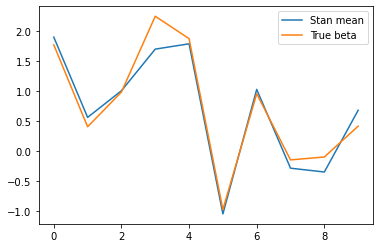

In [27]:
plt.plot(range(10), stan_mean_logistic)
plt.plot(range(10), beta0_logistic)
plt.legend(['Stan mean', 'True beta'], loc='upper right')
plt.show()

# Neural Networks
I have tested different learning rates $\lambda$ and batch_size and found that setting $\lambda=0.001$, batchsize=256 is working. Although we can use early stopping, I just fixed the epochs to 20. Actually, the loss on validation set changed little after the first epoch.

## Normal

In [28]:
torch.manual_seed(0)
md_mean_normal = MLP(N, p).to(device)
train_losses, val_losses = train_model(md_mean_normal, 0.001, 256, 20, Y_normal_train, beta_normal_train, val_data=Y_normal_val, val_labels=beta_normal_val)

Epoch: 1
Train loss: 0.00441
Val loss: 0.00399
Epoch: 2
Train loss: 0.00302
Val loss: 0.00301
Epoch: 3
Train loss: 0.00266
Val loss: 0.00255
Epoch: 4
Train loss: 0.00252
Val loss: 0.00245
Epoch: 5
Train loss: 0.00245
Val loss: 0.00243
Epoch: 6
Train loss: 0.00241
Val loss: 0.00239
Epoch: 7
Train loss: 0.00238
Val loss: 0.00232
Epoch: 8
Train loss: 0.00236
Val loss: 0.00226
Epoch: 9
Train loss: 0.00234
Val loss: 0.00225
Epoch: 10
Train loss: 0.00233
Val loss: 0.00226
Epoch: 11
Train loss: 0.00231
Val loss: 0.00228
Epoch: 12
Train loss: 0.00230
Val loss: 0.00227
Epoch: 13
Train loss: 0.00229
Val loss: 0.00226
Epoch: 14
Train loss: 0.00228
Val loss: 0.00225
Epoch: 15
Train loss: 0.00228
Val loss: 0.00224
Epoch: 16
Train loss: 0.00227
Val loss: 0.00224
Epoch: 17
Train loss: 0.00226
Val loss: 0.00223
Epoch: 18
Train loss: 0.00226
Val loss: 0.00223
Epoch: 19
Train loss: 0.00226
Val loss: 0.00223
Epoch: 20
Train loss: 0.00225
Val loss: 0.00222


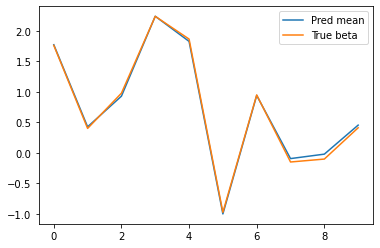

In [29]:
pred_mean_normal = predict(md_mean_normal, (Y0_normal-mean_normal)/std_normal)
plt.plot(range(10), pred_mean_normal)
plt.plot(range(10), beta0_normal)
plt.legend(['Pred mean', 'True beta'], loc='upper right')
plt.show()

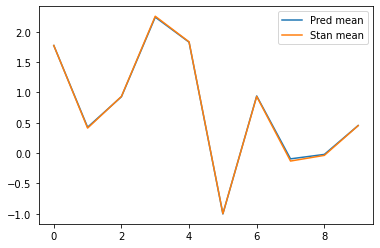

In [30]:
plt.plot(range(10), pred_mean_normal)
plt.plot(range(10), stan_mean_normal)
plt.legend(['Pred mean', 'Stan mean'], loc='upper right')
plt.show()

In [31]:
torch.manual_seed(0)
md_q025_normal = MLP(N, p).to(device)
train_losses, val_losses = train_model(md_q025_normal, 0.001, 256, 20, Y_normal_train, beta_normal_train, 
                                       loss_type='quantile', q=0.025, val_data=Y_normal_val, val_labels=beta_normal_val)

Epoch: 1
Train loss: 0.00594
Val loss: 0.00465
Epoch: 2
Train loss: 0.00428
Val loss: 0.00379
Epoch: 3
Train loss: 0.00377
Val loss: 0.00425
Epoch: 4
Train loss: 0.00354
Val loss: 0.00341
Epoch: 5
Train loss: 0.00342
Val loss: 0.00345
Epoch: 6
Train loss: 0.00335
Val loss: 0.00365
Epoch: 7
Train loss: 0.00330
Val loss: 0.00351
Epoch: 8
Train loss: 0.00327
Val loss: 0.00326
Epoch: 9
Train loss: 0.00323
Val loss: 0.00361
Epoch: 10
Train loss: 0.00321
Val loss: 0.00322
Epoch: 11
Train loss: 0.00319
Val loss: 0.00330
Epoch: 12
Train loss: 0.00317
Val loss: 0.00327
Epoch: 13
Train loss: 0.00315
Val loss: 0.00308
Epoch: 14
Train loss: 0.00315
Val loss: 0.00323
Epoch: 15
Train loss: 0.00314
Val loss: 0.00314
Epoch: 16
Train loss: 0.00312
Val loss: 0.00313
Epoch: 17
Train loss: 0.00311
Val loss: 0.00313
Epoch: 18
Train loss: 0.00310
Val loss: 0.00340
Epoch: 19
Train loss: 0.00309
Val loss: 0.00313
Epoch: 20
Train loss: 0.00309
Val loss: 0.00319


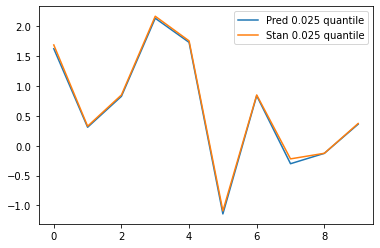

In [32]:
pred_q025_normal = predict(md_q025_normal, (Y0_normal-mean_normal)/std_normal)
plt.plot(range(10), pred_q025_normal)
plt.plot(range(10), stan_q025_normal)
plt.legend(['Pred 0.025 quantile', 'Stan 0.025 quantile'], loc='upper right')
plt.show()

In [33]:
torch.manual_seed(0)
md_q975_normal = MLP(N, p).to(device)
train_losses, val_losses = train_model(md_q975_normal, 0.001, 256, 20, Y_normal_train, beta_normal_train, 
                                       loss_type='quantile', q=0.975, val_data=Y_normal_val, val_labels=beta_normal_val)

Epoch: 1
Train loss: 0.00594
Val loss: 0.00492
Epoch: 2
Train loss: 0.00423
Val loss: 0.00432
Epoch: 3
Train loss: 0.00374
Val loss: 0.00360
Epoch: 4
Train loss: 0.00353
Val loss: 0.00348
Epoch: 5
Train loss: 0.00342
Val loss: 0.00333
Epoch: 6
Train loss: 0.00336
Val loss: 0.00348
Epoch: 7
Train loss: 0.00331
Val loss: 0.00316
Epoch: 8
Train loss: 0.00328
Val loss: 0.00313
Epoch: 9
Train loss: 0.00324
Val loss: 0.00321
Epoch: 10
Train loss: 0.00321
Val loss: 0.00345
Epoch: 11
Train loss: 0.00320
Val loss: 0.00335
Epoch: 12
Train loss: 0.00320
Val loss: 0.00319
Epoch: 13
Train loss: 0.00317
Val loss: 0.00325
Epoch: 14
Train loss: 0.00315
Val loss: 0.00314
Epoch: 15
Train loss: 0.00312
Val loss: 0.00317
Epoch: 16
Train loss: 0.00310
Val loss: 0.00315
Epoch: 17
Train loss: 0.00309
Val loss: 0.00299
Epoch: 18
Train loss: 0.00308
Val loss: 0.00300
Epoch: 19
Train loss: 0.00308
Val loss: 0.00297
Epoch: 20
Train loss: 0.00307
Val loss: 0.00300


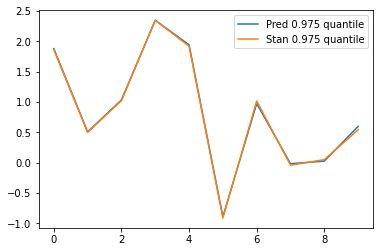

In [34]:
pred_q975_normal = predict(md_q975_normal, (Y0_normal-mean_normal)/std_normal)
plt.plot(range(10), pred_q975_normal)
plt.plot(range(10), stan_q975_normal)
plt.legend(['Pred 0.975 quantile', 'Stan 0.975 quantile'], loc='upper right')
plt.show()

In [35]:
torch.manual_seed(0)
md_sqr_normal = MLP(N+1, p).to(device)
train_model_sqr(md_sqr_normal, 0.001, 256, 20, Y_normal_train, beta_normal_train)
model_test_sqr(md_sqr_normal, Y_normal_val, beta_normal_val)

Epoch: 1
Train loss: 0.01977
Epoch: 2
Train loss: 0.01644
Epoch: 3
Train loss: 0.01529
Epoch: 4
Train loss: 0.01482
Epoch: 5
Train loss: 0.01454
Epoch: 6
Train loss: 0.01437
Epoch: 7
Train loss: 0.01424
Epoch: 8
Train loss: 0.01412
Epoch: 9
Train loss: 0.01403
Epoch: 10
Train loss: 0.01399
Epoch: 11
Train loss: 0.01393
Epoch: 12
Train loss: 0.01391
Epoch: 13
Train loss: 0.01390
Epoch: 14
Train loss: 0.01387
Epoch: 15
Train loss: 0.01386
Epoch: 16
Train loss: 0.01385
Epoch: 17
Train loss: 0.01383
Epoch: 18
Train loss: 0.01381
Epoch: 19
Train loss: 0.01377
Epoch: 20
Train loss: 0.01378


0.014010703191161156

In [36]:
pred_q025_sqr_normal = predict_sqr(md_sqr_normal, (Y0_normal-mean_normal)/std_normal, 0.025)
pred_q975_sqr_normal = predict_sqr(md_sqr_normal, (Y0_normal-mean_normal)/std_normal, 0.975)

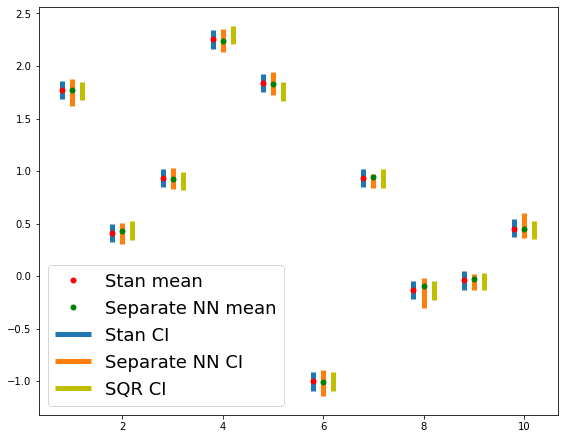

In [37]:
plt.figure(figsize=(9.3,7.5))
plt.plot(np.arange(p)+1-0.2, stan_mean_normal, '.r', ms=10)
plt.vlines(np.arange(p)+1-0.2, stan_q025_normal, stan_q975_normal, lw=5)
plt.plot(np.arange(p)+1, pred_mean_normal.reshape(-1), '.g', ms=10)
plt.vlines(np.arange(p)+1, pred_q025_normal.reshape(-1), pred_q975_normal.reshape(-1),color='#ff7f0e', lw=5)
plt.vlines(np.arange(p)+1+0.2, pred_q025_sqr_normal.reshape(-1), pred_q975_sqr_normal.reshape(-1), color='y', lw=5)
plt.legend(['Stan mean', 'Separate NN mean', 'Stan CI', 'Separate NN CI', 'SQR CI'], loc='lower left', ncol=1, fontsize=18)
plt.show()

## Logistic

In [41]:
torch.manual_seed(1)
md_mean_logistic = MLP(N, p).to(device)
train_losses, val_losses = train_model(md_mean_logistic, 0.001, 256, 20, Y_logistic_train, beta_logistic_train, val_data=Y_logistic_val, val_labels=beta_logistic_val)

Epoch: 1
Train loss: 0.03978
Val loss: 0.03438
Epoch: 2
Train loss: 0.03228
Val loss: 0.03291
Epoch: 3
Train loss: 0.03066
Val loss: 0.03257
Epoch: 4
Train loss: 0.02974
Val loss: 0.03270
Epoch: 5
Train loss: 0.02911
Val loss: 0.03263
Epoch: 6
Train loss: 0.02864
Val loss: 0.03269
Epoch: 7
Train loss: 0.02824
Val loss: 0.03295
Epoch: 8
Train loss: 0.02790
Val loss: 0.03291
Epoch: 9
Train loss: 0.02762
Val loss: 0.03281
Epoch: 10
Train loss: 0.02738
Val loss: 0.03270
Epoch: 11
Train loss: 0.02714
Val loss: 0.03277
Epoch: 12
Train loss: 0.02694
Val loss: 0.03317
Epoch: 13
Train loss: 0.02677
Val loss: 0.03291
Epoch: 14
Train loss: 0.02661
Val loss: 0.03292
Epoch: 15
Train loss: 0.02645
Val loss: 0.03273
Epoch: 16
Train loss: 0.02630
Val loss: 0.03277
Epoch: 17
Train loss: 0.02616
Val loss: 0.03281
Epoch: 18
Train loss: 0.02604
Val loss: 0.03297
Epoch: 19
Train loss: 0.02592
Val loss: 0.03283
Epoch: 20
Train loss: 0.02580
Val loss: 0.03286


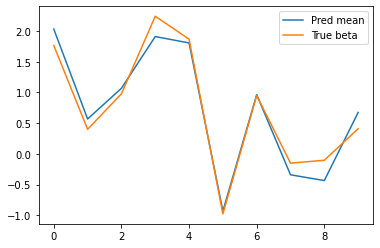

In [42]:
pred_mean_logistic = predict(md_mean_logistic, (Y0_logistic-mean_logistic)/std_logistic)
plt.plot(range(10), pred_mean_logistic)
plt.plot(range(10), beta0_logistic)
plt.legend(['Pred mean', 'True beta'], loc='upper right')
plt.show()

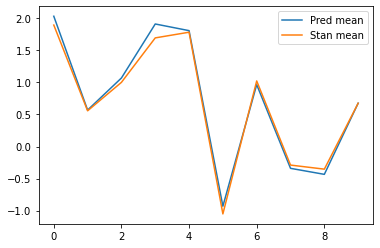

In [43]:
plt.plot(range(10), pred_mean_logistic)
plt.plot(range(10), stan_mean_logistic)
plt.legend(['Pred mean', 'Stan mean'], loc='upper right')
plt.show()

In [44]:
torch.manual_seed(0)
md_q025_logistic = MLP(N, p).to(device)
train_losses, val_losses = train_model(md_q025_logistic, 0.001, 256, 20, Y_logistic_train, beta_logistic_train, 
                                       loss_type='quantile', q=0.025, val_data=Y_logistic_val, val_labels=beta_logistic_val)

Epoch: 1
Train loss: 0.01406
Val loss: 0.01240
Epoch: 2
Train loss: 0.01203
Val loss: 0.01193
Epoch: 3
Train loss: 0.01149
Val loss: 0.01157
Epoch: 4
Train loss: 0.01120
Val loss: 0.01157
Epoch: 5
Train loss: 0.01101
Val loss: 0.01147
Epoch: 6
Train loss: 0.01089
Val loss: 0.01143
Epoch: 7
Train loss: 0.01076
Val loss: 0.01125
Epoch: 8
Train loss: 0.01066
Val loss: 0.01149
Epoch: 9
Train loss: 0.01057
Val loss: 0.01180
Epoch: 10
Train loss: 0.01050
Val loss: 0.01143
Epoch: 11
Train loss: 0.01043
Val loss: 0.01121
Epoch: 12
Train loss: 0.01036
Val loss: 0.01154
Epoch: 13
Train loss: 0.01030
Val loss: 0.01145
Epoch: 14
Train loss: 0.01023
Val loss: 0.01109
Epoch: 15
Train loss: 0.01020
Val loss: 0.01144
Epoch: 16
Train loss: 0.01015
Val loss: 0.01163
Epoch: 17
Train loss: 0.01010
Val loss: 0.01182
Epoch: 18
Train loss: 0.01006
Val loss: 0.01138
Epoch: 19
Train loss: 0.01002
Val loss: 0.01168
Epoch: 20
Train loss: 0.00999
Val loss: 0.01166


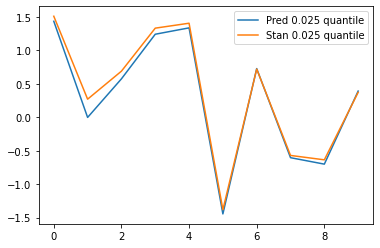

In [45]:
pred_q025_logistic = predict(md_q025_logistic, (Y0_logistic-mean_logistic)/std_logistic)
plt.plot(range(10), pred_q025_logistic)
plt.plot(range(10), stan_q025_logistic)
plt.legend(['Pred 0.025 quantile', 'Stan 0.025 quantile'], loc='upper right')
plt.show()

In [46]:
torch.manual_seed(0)
md_q975_logistic = MLP(N, p).to(device)
train_losses, val_losses = train_model(md_q975_logistic, 0.001, 256, 20, Y_logistic_train, beta_logistic_train, 
                                       loss_type='quantile', q=0.975, val_data=Y_logistic_val, val_labels=beta_logistic_val)

Epoch: 1
Train loss: 0.01406
Val loss: 0.01306
Epoch: 2
Train loss: 0.01208
Val loss: 0.01206
Epoch: 3
Train loss: 0.01156
Val loss: 0.01190
Epoch: 4
Train loss: 0.01126
Val loss: 0.01149
Epoch: 5
Train loss: 0.01109
Val loss: 0.01144
Epoch: 6
Train loss: 0.01093
Val loss: 0.01141
Epoch: 7
Train loss: 0.01082
Val loss: 0.01149
Epoch: 8
Train loss: 0.01072
Val loss: 0.01143
Epoch: 9
Train loss: 0.01063
Val loss: 0.01160
Epoch: 10
Train loss: 0.01056
Val loss: 0.01129
Epoch: 11
Train loss: 0.01049
Val loss: 0.01134
Epoch: 12
Train loss: 0.01042
Val loss: 0.01121
Epoch: 13
Train loss: 0.01036
Val loss: 0.01129
Epoch: 14
Train loss: 0.01030
Val loss: 0.01130
Epoch: 15
Train loss: 0.01025
Val loss: 0.01121
Epoch: 16
Train loss: 0.01019
Val loss: 0.01128
Epoch: 17
Train loss: 0.01016
Val loss: 0.01136
Epoch: 18
Train loss: 0.01010
Val loss: 0.01172
Epoch: 19
Train loss: 0.01006
Val loss: 0.01123
Epoch: 20
Train loss: 0.01002
Val loss: 0.01137


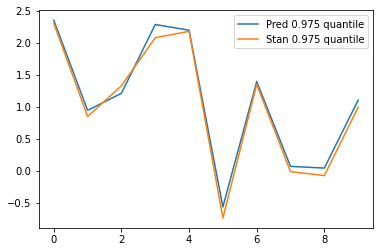

In [47]:
pred_q975_logistic = predict(md_q975_logistic, (Y0_logistic-mean_logistic)/std_logistic)
plt.plot(range(10), pred_q975_logistic)
plt.plot(range(10), stan_q975_logistic)
plt.legend(['Pred 0.975 quantile', 'Stan 0.975 quantile'], loc='upper right')
plt.show()

In [48]:
torch.manual_seed(0)
md_sqr_logistic = MLP(N+1, p).to(device)
train_model_sqr(md_sqr_logistic, 0.001, 256, 20, Y_logistic_train, beta_logistic_train)
model_test_sqr(md_sqr_logistic, Y_logistic_val, beta_logistic_val)

Epoch: 1
Train loss: 0.05750
Epoch: 2
Train loss: 0.05185
Epoch: 3
Train loss: 0.05050
Epoch: 4
Train loss: 0.04983
Epoch: 5
Train loss: 0.04933
Epoch: 6
Train loss: 0.04895
Epoch: 7
Train loss: 0.04854
Epoch: 8
Train loss: 0.04831
Epoch: 9
Train loss: 0.04811
Epoch: 10
Train loss: 0.04790
Epoch: 11
Train loss: 0.04763
Epoch: 12
Train loss: 0.04748
Epoch: 13
Train loss: 0.04732
Epoch: 14
Train loss: 0.04717
Epoch: 15
Train loss: 0.04706
Epoch: 16
Train loss: 0.04694
Epoch: 17
Train loss: 0.04678
Epoch: 18
Train loss: 0.04668
Epoch: 19
Train loss: 0.04651
Epoch: 20
Train loss: 0.04645


0.049479663372039795

In [49]:
pred_q025_sqr_logistic = predict_sqr(md_sqr_logistic, (Y0_logistic-mean_logistic)/std_logistic, 0.025)
pred_q975_sqr_logistic = predict_sqr(md_sqr_logistic, (Y0_logistic-mean_logistic)/std_logistic, 0.975)

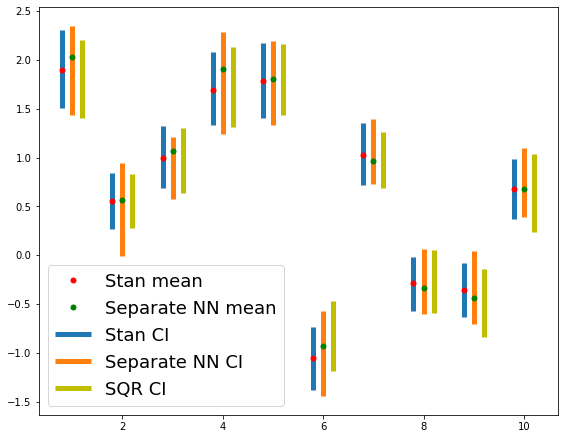

In [50]:
plt.figure(figsize=(9.3,7.5))
plt.plot(np.arange(p)+1-0.2, stan_mean_logistic, '.r', ms=10)
plt.vlines(np.arange(p)+1-0.2, stan_q025_logistic, stan_q975_logistic, lw=5)
plt.plot(np.arange(p)+1, pred_mean_logistic.reshape(-1), '.g', ms=10)
plt.vlines(np.arange(p)+1, pred_q025_logistic.reshape(-1), pred_q975_logistic.reshape(-1),color='#ff7f0e', lw=5)
plt.vlines(np.arange(p)+1+0.2, pred_q025_sqr_logistic.reshape(-1), pred_q975_sqr_logistic.reshape(-1), color='y', lw=5)
plt.legend(['Stan mean', 'Separate NN mean', 'Stan CI', 'Separate NN CI', 'SQR CI'], loc='lower left', ncol=1, fontsize=18)
plt.show()

## Summary
The results of neural networks seem to be comparable with the results of Stan. The confidence intervals obtained by SQR seem to be slightly better than that obtained by separate neural networks. The posterior mean obtained by neural network is not at the middle of the confidence interval.

# Sequential Neural Postrior estimation (SNPE)

In [51]:
from torch.distributions.multivariate_normal import MultivariateNormal
from sbi.inference.base import infer
from sbi import analysis as analysis
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi

## Logistic

### Single-round inference
Amortized inference: we can evaluate the posterior for different observation to the inference procedure.

In [88]:
prior = MultivariateNormal(torch.zeros(p), torch.eye(p))
def simulator(beta):
    X_tensor = torch.from_numpy(X).type(torch.float)
    prob = torch.exp(X_tensor@beta) / (1 + torch.exp(X_tensor@beta))
    return torch.bernoulli(prob)

In [102]:
torch.manual_seed(0)
posterior = infer(simulator, prior, method="SNPE", num_simulations=50000) # the value of num_simulations may not be optimal

Running 50000 simulations.:   0%|          | 0/50000 [00:00<?, ?it/s]

 Neural network successfully converged after 28 epochs.

In [103]:
torch.manual_seed(0)
pos_samples = posterior.sample((10000,), x=Y0_logistic).numpy()
snpe_mean = np.mean(pos_samples, 0)
snpe_q025 = np.quantile(pos_samples, 0.025, 0)
snpe_q975 = np.quantile(pos_samples, 0.975, 0)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

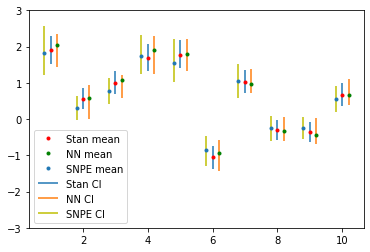

In [106]:
plt.plot(np.arange(p)+1, stan_mean_logistic, '.r')
plt.vlines(np.arange(p)+1, stan_q025_logistic, stan_q975_logistic)
plt.plot(np.arange(p)+1+0.2, pred_mean_logistic.reshape(-1), '.g')
plt.vlines(np.arange(p)+1+0.2, pred_q025_logistic.reshape(-1), pred_q975_logistic.reshape(-1),color='#ff7f0e')
plt.plot(np.arange(p)+1-0.2, snpe_mean, '.')
plt.vlines(np.arange(p)+1-0.2, snpe_q025, snpe_q975, color='y')
plt.legend(['Stan mean', 'NN mean', 'SNPE mean', 'Stan CI', 'NN CI', 'SNPE CI'], loc='lower left')
plt.ylim(-3,3)
plt.show()

### Multi-round inference
In each new round of inference, it uses the posterior got in last round as proposal. Posterior no longer being amortized.

In [110]:
torch.manual_seed(0)
x_o = Y0_logistic
num_rounds = 2
posteriors = []
simulator, prior = prepare_for_sbi(simulator, prior)
proposal = prior
inference = SNPE(prior=prior)
for _ in range(num_rounds):
    beta_sbi, x_sbi = simulate_for_sbi(simulator, proposal, num_simulations=10000)
    density_estimator = inference.append_simulations(beta_sbi, x_sbi, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 24 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 72 epochs.

In [111]:
torch.manual_seed(0)
pos_samples_2rounds = posterior.sample((10000,), x=Y0_logistic).numpy()
snpe_mean_2rounds = np.mean(pos_samples_2rounds, 0)
snpe_q025_2rounds = np.quantile(pos_samples_2rounds, 0.025, 0)
snpe_q975_2rounds = np.quantile(pos_samples_2rounds, 0.975, 0)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

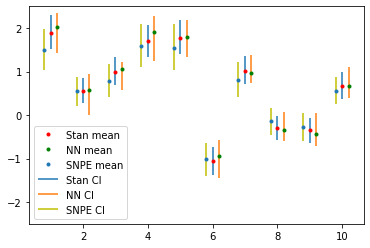

In [114]:
plt.plot(np.arange(p)+1, stan_mean_logistic, '.r')
plt.vlines(np.arange(p)+1, stan_q025_logistic, stan_q975_logistic)
plt.plot(np.arange(p)+1+0.2, pred_mean_logistic.reshape(-1), '.g')
plt.vlines(np.arange(p)+1+0.2, pred_q025_logistic.reshape(-1), pred_q975_logistic.reshape(-1),color='#ff7f0e')
plt.plot(np.arange(p)+1-0.2, snpe_mean_2rounds, '.')
plt.vlines(np.arange(p)+1-0.2, snpe_q025_2rounds, snpe_q975_2rounds, color='y')
plt.legend(['Stan mean', 'NN mean', 'SNPE mean', 'Stan CI', 'NN CI', 'SNPE CI'], loc='lower left')
plt.ylim(-2.5,2.5)
plt.show()

## Summary
The results of SNPE seem to be a little worse than that of our method. Under this situation, the cost of simulation is low, so it is more efficient to use single-round inference.